In [1]:
import pandas as pd
import numpy as np
import os
path_in = os.path.join("Data")  # parent directory
np.random.seed(42)

import sys
sys.path.append(os.path.abspath("../src/RC-Model"))  # now src is on sys.path

from models import * 
from simulate import *
from plot import *
from train import *
from split_dataset import *

%load_ext autoreload
%autoreload 2

# === Paths ===
###################### ======================== Case Study 1 ======================= ###########################

file_path = os.path.join(path_in, "dataset2.xlsx")
cs1 = pd.read_excel(file_path)

cs1["INDOOR_TEMP"] = cs1[["RTD31", "RTD34", "RTD37", "RTD40", "RTD41"]].mean(axis=1)
# Rename columns
rename_mapping = {
        'Tout': 'OUTDOOR_TEMP',
        'PhRad_actual_power': 'PHI_H',
        'SolGlob': 'PYRANOMETER'
    }
cs1 = cs1.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs1['Time'] = pd.to_datetime(cs1['Time'])
cs1 = cs1.set_index('Time')
cs1_surface_area = 100  # m² 
cs1 = cs1.iloc[0:960]

train_cs1, val_cs1, test_cs1 = split_dataset(cs1, testing_days=3, val_split=0.3)

###################### ======================== Case Study 2 ======================= ###########################

file_path = os.path.join(path_in, "dataset4.xlsx")
cs2 = pd.read_excel(file_path)
# Rename columns
rename_mapping = {
        'T_ext': 'OUTDOOR_TEMP',
        'heating_total [kW]': 'PHI_H',
        'GHI': 'PYRANOMETER',
        'T_int': 'INDOOR_TEMP'
    }
cs2 = cs2.rename(columns=rename_mapping)
cs2['PHI_H']=cs2['PHI_H']*1000
# Convert 't' to datetime and set as index

cs2['Time'] = pd.to_datetime(cs2['Time'])
cs2 = cs2.set_index('Time')
cs2 = cs2.resample("30min").mean()
cs2_surface_area = 2100  # m² 
cs2 = cs2.iloc[0:960]

train_cs2, val_cs2, test_cs2 = split_dataset(cs2, testing_days=3, val_split=0.3)

###################### ======================== Case Study 3 ======================= ###########################

file_path = os.path.join(path_in, "dataset5-cella.xlsx")
cs3 = pd.read_excel(file_path)
cs3["INDOOR_TEMP"] = cs3[["ra_zone_air_temp1_C", "ra_zone_air_temp2_C"]].mean(axis=1)
cs3['PHI_H']=cs3['ra_sup_air_flow_cmh']/3600*1.2*(cs3['ra_sup_air_temp_C']-cs3['INDOOR_TEMP'])*1005
# Rename columns
rename_mapping = {
        'oat_C': 'OUTDOOR_TEMP',
        'global_irradiance_Wm2': 'PYRANOMETER',
    }
cs3 = cs3.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs3['time'] = pd.to_datetime(cs3['time'])
cs3 = cs3.set_index('time')
cs3 = cs3.resample("30min").mean()
cs3=cs3[cs3.index>'2020-07-21']
cs3_surface_area = 57  # m² 
cs3= cs3.iloc[0:960]

train_cs3, val_cs3, test_cs3 = split_dataset(cs3, testing_days=3, val_split=0.3)

###################### ======================== Case Study 4 ======================= ###########################

file_path = os.path.join(path_in, "dataset5-cellb.xlsx")
cs4 = pd.read_excel(file_path)
cs4["INDOOR_TEMP"] = cs4[["rb_zone_air_temp1_C", "rb_zone_air_temp2_C"]].mean(axis=1)
cs4['PHI_H']=cs4['rb_sup_air_flow_cmh']/3600*1.2*(cs4['rb_sup_air_temp_C']-cs4['INDOOR_TEMP'])*1005
# Rename columns
rename_mapping = {
        'oat_C': 'OUTDOOR_TEMP',
        'global_irradiance_Wm2': 'PYRANOMETER',
    }
cs4 = cs4.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs4['time'] = pd.to_datetime(cs4['time'])
cs4 = cs4.set_index('time')
cs4 = cs4.resample("30min").mean()
cs4=cs4[cs4.index>'2020-07-21']
cs4_surface_area = 57  # m² 
cs4= cs4.iloc[0:960]

train_cs4, val_cs4, test_cs4 = split_dataset(cs4, testing_days=3, val_split=0.3)

## 1R1C


=== Best result ===
Best Trial Validation #: 14
Best Trial Training #: 13
Best RMSE Validation: 0.2818
RMSE Training of Best Validation : 0.0226
Best RMSE Training: 0.0226
Best initialization Validation: {'R_in_a': 0.40556361878881225, 'C_in': 499397674.9720116, 'Ain': 1.649934238887822}
Best initialization Training: {'R_in_a': 0.5802497464716773, 'C_in': 141992583.49180079, 'Ain': 8.37096970214355}
Best parameters Validation: {'R_in_a': 0.013474304906168546, 'C_in': 23043303.48838628, 'Ain': 3.4724821937070396, 'fh': 1, 'Objective': 0.022632530669965678, 'Solve_time': 0.040332794189453125}
Best parameters Training: {'R_in_a': 0.013474304904534638, 'C_in': 23043303.487767197, 'Ain': 3.4724821999673057, 'fh': 1, 'Objective': 0.022632530669963607, 'Solve_time': 0.03609108924865723}
Solve Time: 2.667282819747925


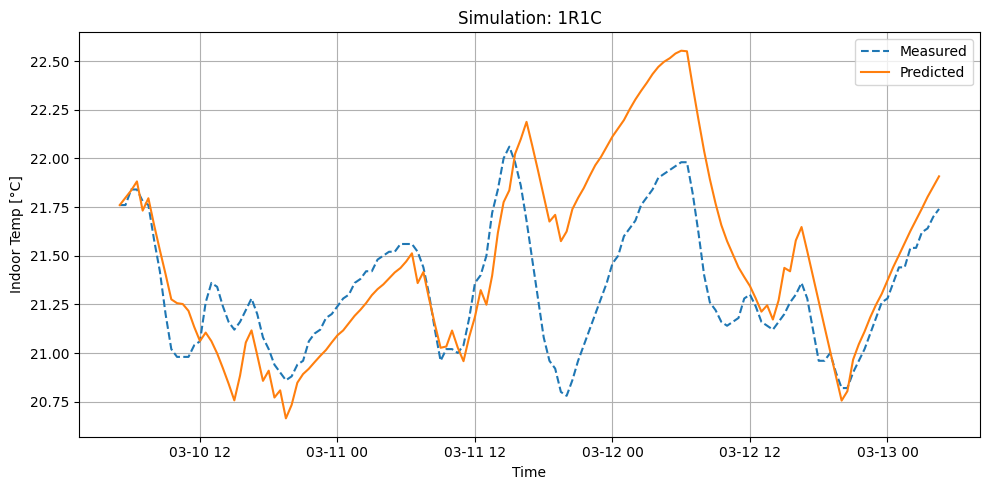


=== Best result ===
Best Trial Validation #: 17
Best Trial Training #: 17
Best RMSE Validation: 1.3382
RMSE Training of Best Validation : 0.7585
Best RMSE Training: 0.7585
Best initialization Validation: {'R_in_a': 0.30953860213369205, 'C_in': 9749067823.829538, 'Ain': 259.0020415933376}
Best initialization Training: {'R_in_a': 0.30953860213369205, 'C_in': 9749067823.829538, 'Ain': 259.0020415933376}
Best parameters Validation: {'R_in_a': 0.0004278483857984514, 'C_in': 2477035460.291146, 'Ain': 630.0000019495444, 'fh': 1, 'Objective': 0.7585099308237238, 'Solve_time': 0.03279900550842285}
Best parameters Training: {'R_in_a': 0.0004278483857984514, 'C_in': 2477035460.291146, 'Ain': 630.0000019495444, 'fh': 1, 'Objective': 0.7585099308237238, 'Solve_time': 0.03279900550842285}
Solve Time: 1.0255687236785889


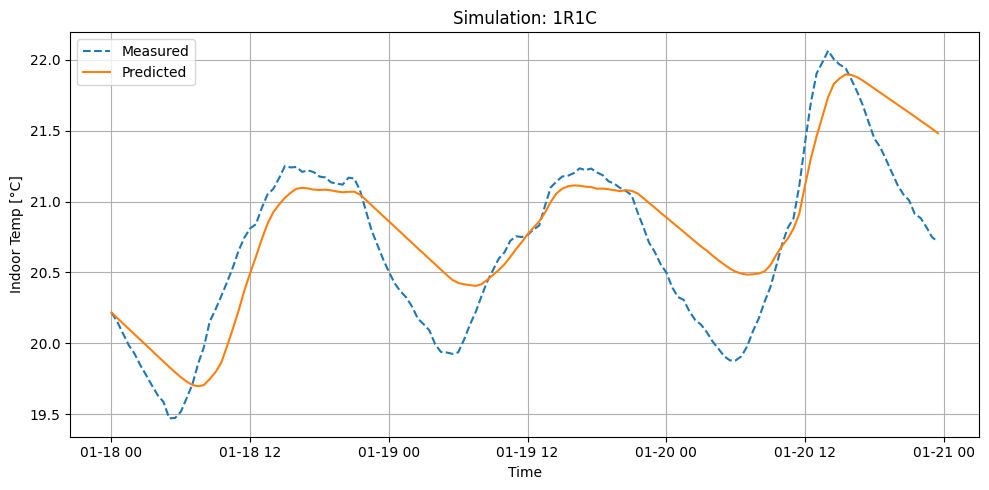


=== Best result ===
Best Trial Validation #: 18
Best Trial Training #: 24
Best RMSE Validation: 1.0638
RMSE Training of Best Validation : 1.3413
Best RMSE Training: 1.3413
Best initialization Validation: {'R_in_a': 0.11515168931257164, 'C_in': 7758996667.44246, 'Ain': 13.816262353336112}
Best initialization Training: {'R_in_a': 0.694726967953585, 'C_in': 7950320357.747775, 'Ain': 2.794197736158232}
Best parameters Validation: {'R_in_a': 0.01196626380092606, 'C_in': 51157094.84364432, 'Ain': 5.347694287749237, 'fh': 1, 'Objective': 1.3413199987817903, 'Solve_time': 0.9446141719818115}
Best parameters Training: {'R_in_a': 0.011966263800926748, 'C_in': 51157094.84364153, 'Ain': 5.347694287749081, 'fh': 1, 'Objective': 1.3413199987817828, 'Solve_time': 0.2303779125213623}
Solve Time: 6.657936096191406


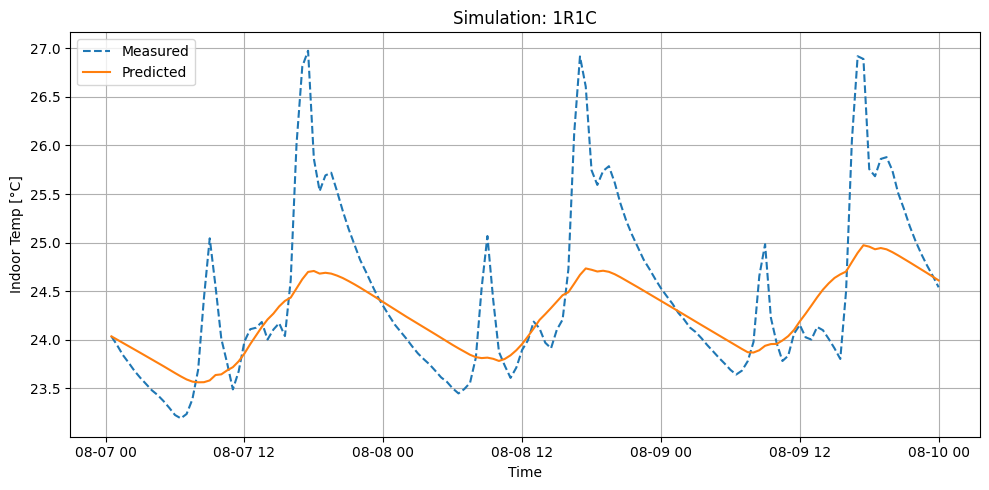


=== Best result ===
Best Trial Validation #: 6
Best Trial Training #: 2
Best RMSE Validation: 1.3436
RMSE Training of Best Validation : 0.5237
Best RMSE Training: 0.3822
Best initialization Validation: {'R_in_a': 0.8380147916362953, 'C_in': 4872222113.881738, 'Ain': 16.682817215659597}
Best initialization Training: {'R_in_a': 0.12137809922136542, 'C_in': 3679866111.4633703, 'Ain': 4.704915775779468}
Best parameters Validation: {'R_in_a': 0.07231402366385599, 'C_in': 24864889.962727588, 'Ain': 3.056903469214921, 'fh': 1, 'Objective': 0.5236666149101388, 'Solve_time': 0.9677236080169678}
Best parameters Training: {'R_in_a': 0.11459291575160499, 'C_in': 13263957.233189065, 'Ain': 2.802206432600936, 'fh': 1, 'Objective': 0.38220469924845185, 'Solve_time': 0.8761098384857178}
Solve Time: 3.977158546447754


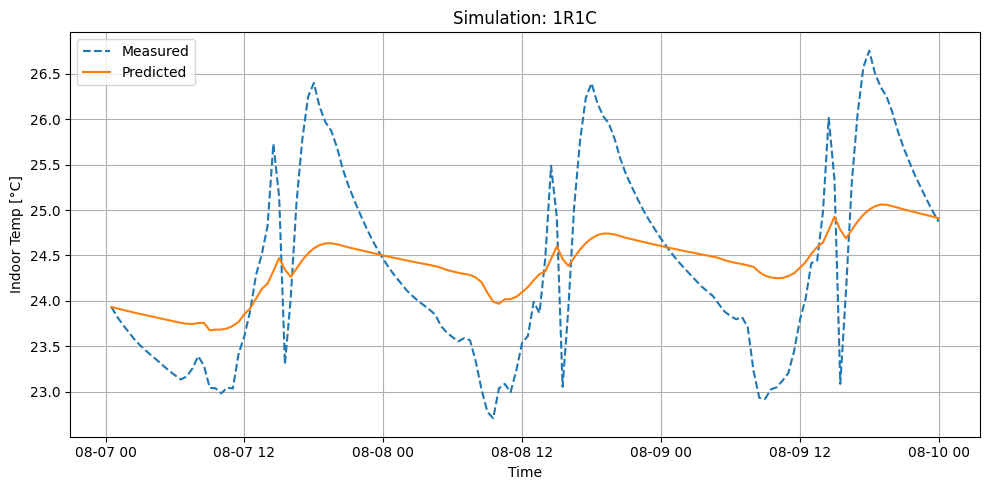

In [32]:
bounds_cs1 = {
        "R_in_a": (0.001, 1),
        "C_in": (1e6, 5e8),
        "Ain": (0.001, 0.3 * cs1_surface_area)
    }
bounds_cs2 = {
        "R_in_a": (0.0001, 1),
        "C_in": (1e6, 1e10),
        "Ain": (0.001, 0.3 * cs2_surface_area)
    }
bounds_cs3 = {
        "R_in_a": (0.01, 1),
        "C_in": (1e6, 1e10),
        "Ain": (0.001, 0.3 * cs3_surface_area)
    }
bounds_cs4 = {
        "R_in_a": (0.01, 1),
        "C_in": (1e6, 5e9),
        "Ain": (0.001, 0.3 * cs4_surface_area)
    }

###################### ======================== Case Study 1 ======================= ###########################

model_1r1c_cs1, parameters_1r1c_cs1, best_initialization_1r1c_cs1, validation_pred_1r1c_cs1, initialize_testing_1r1c_cs1, all_trials_1r1c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="1R1C", bounds=bounds_cs1, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_1r1c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0] # The initialization must be 

# --- Run Simulation for Testing ---
testing_performance_1r1c_cs1, testing_df_1r1c_cs1 = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_1r1c_cs1, model_type="1R1C",
        initializations=initialize_testing_1r1c_cs1, show_plot=True
    )

# ###################### ======================== Case Study 2 ======================= ###########################

model_1r1c_cs2, parameters_1r1c_cs2, best_initialization_1r1c_cs2, validation_pred_1r1c_cs2, initialize_testing_1r1c_cs2, all_trials_1r1c_cs2 = train_greybox_model_with_validation_process(
    train_df=train_cs2, val_df=val_cs2, model_type="1R1C", bounds=bounds_cs2, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)
initialize_testing_1r1c_cs2['Tin'] = test_cs2['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_1r1c_cs2, testing_df_1r1c_cs2  = simulate_and_evaluate(
        val_df=test_cs2, param_dict=parameters_1r1c_cs2, model_type="1R1C", 
        initializations=initialize_testing_1r1c_cs2, show_plot=True
    )

# ###################### ======================== Case Study 3 ======================= ###########################

model_1r1c_cs3, parameters_1r1c_cs3, best_initialization_1r1c_cs3, validation_pred_1r1c_cs3, initialize_testing_1r1c_cs3, all_trials_1r1c_cs3 = train_greybox_model_with_validation_process(
    train_df=train_cs3, val_df=val_cs3, model_type="1R1C", bounds=bounds_cs3, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)
initialize_testing_1r1c_cs3['Tin'] = test_cs3['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_1r1c_cs3, testing_df_1r1c_cs3  = simulate_and_evaluate(
        val_df=test_cs3, param_dict=parameters_1r1c_cs3, model_type="1R1C", 
        initializations=initialize_testing_1r1c_cs3, show_plot=True
    )

###################### ======================== Case Study 4 ======================= ###########################

model_1r1c_cs4, parameters_1r1c_cs4, best_initialization_1r1c_cs4, validation_pred_1r1c_cs4, initialize_testing_1r1c_cs4, all_trials_1r1c_cs4 = train_greybox_model_with_validation_process(
    train_df=train_cs4, val_df=val_cs4, model_type="1R1C", bounds=bounds_cs4, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)
initialize_testing_1r1c_cs4['Tin'] = test_cs4['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_1r1c_cs4, testing_df_1r1c_cs4  = simulate_and_evaluate(
        val_df=test_cs4, param_dict=parameters_1r1c_cs4, model_type="1R1C", 
        initializations=initialize_testing_1r1c_cs4, show_plot=True
    )

# 2R2C


=== Best result ===
Best Trial Validation #: 20
Best Trial Training #: 6
Best RMSE Validation: 0.2249
RMSE Training of Best Validation : 0.0199
Best RMSE Training: 0.0198
Best initialization Validation: {'R_e_a': 0.6526288317056278, 'R_in_e': 0.4057919454327544, 'C_in': 298425754.14334595, 'C_e': 54617825.76182515, 'Ain': 0.5083670848482981, 'Ae': 27.287023256981655, 'fh': 0.2696300087671828}
Best initialization Training: {'R_e_a': 0.9149201150468812, 'R_in_e': 0.21250265777582286, 'C_in': 72975770.53793366, 'C_e': 379729439.0951613, 'Ain': 15.019085350485595, 'Ae': 27.35364158634076, 'fh': 0.14661455715984228}
Best parameters Validation: {'R_in_e': 0.04791049464297871, 'R_e_a': 0.0014047818366849307, 'C_in': 6268255.01588672, 'C_e': 1000009.461353823, 'Ain': 0.39008184886004915, 'Ae': 12.3718224624455, 'fh': 0.2562735848408568, 'Objective': 0.019857894976493182, 'Solve_time': 0.2600259780883789}
Best parameters Training: {'R_in_e': 0.0012273623768963631, 'R_e_a': 0.012656098822858626

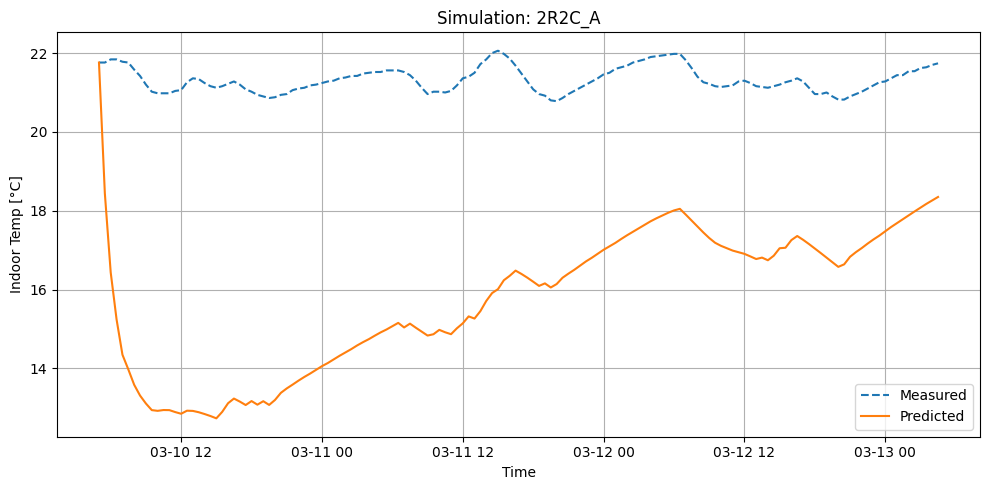


=== Best result ===
Best Trial Validation #: 24
Best Trial Training #: 4
Best RMSE Validation: 1.3723
RMSE Training of Best Validation : 0.7881
Best RMSE Training: 0.5270
Best initialization Validation: {'R_e_a': 0.5464744763307855, 'R_in_e': 0.08992838624898203, 'C_in': 4180422870.9836287, 'C_e': 8532994700.873452, 'Ain': 539.376925703014, 'Ae': 62.52062966173411, 'fh': 0.09072088274783086}
Best initialization Training: {'R_e_a': 0.448361444539435, 'R_in_e': 0.48815624518166223, 'C_in': 2043360422.8960276, 'C_e': 6268399498.018374, 'Ain': 226.0084228995093, 'Ae': 627.2564656596634, 'fh': 0.48018351526188785}
Best parameters Validation: {'R_in_e': 0.0004999900319778075, 'R_e_a': 0.0004999900014792408, 'C_in': 1262448460.2323415, 'C_e': 38509861.97095828, 'Ain': 226.04895239182622, 'Ae': 0.0010358392502177291, 'fh': -7.076901508775457e-09, 'Objective': 0.7880965559086544, 'Solve_time': 2.8094000816345215}
Best parameters Training: {'R_in_e': 0.0008584122002195033, 'R_e_a': 0.0004999900

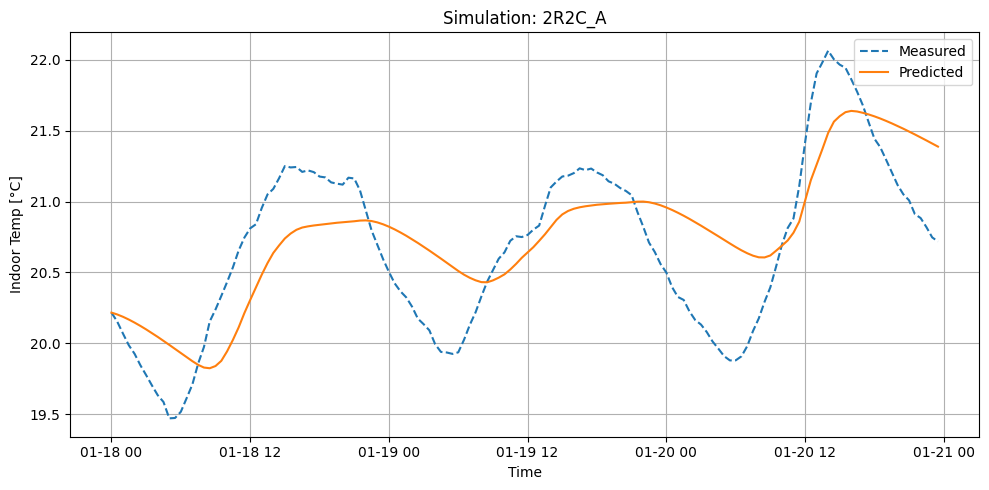


=== Best result ===
Best Trial Validation #: 1
Best Trial Training #: 14
Best RMSE Validation: 0.9290
RMSE Training of Best Validation : 1.2541
Best RMSE Training: 0.5509
Best initialization Validation: {'R_e_a': 0.3347115028715396, 'R_in_e': 0.10771417197102662, 'C_in': 123228354.39978543, 'C_e': 474894180.01921195, 'Ain': 5.217899544927085, 'Ae': 2.8883249888869362, 'fh': 0.4606727916549932}
Best initialization Training: {'R_e_a': 0.1369201781972113, 'R_in_e': 0.8362428218944856, 'C_in': 81619087.24882543, 'C_e': 154081915.5636926, 'Ain': 4.25825599876018, 'Ae': 6.367079078500543, 'fh': 0.25466376588996187}
Best parameters Validation: {'R_in_e': 0.0016444397066240866, 'R_e_a': 0.000999990555503088, 'C_in': 107587515.25703894, 'C_e': 445217927.88227195, 'Ain': 14.511040413395351, 'Ae': 0.0010098532042840064, 'fh': 0.9999999749572606, 'Objective': 1.2541437809361657, 'Solve_time': 0.11029815673828125}
Best parameters Training: {'R_in_e': 0.002031956102448438, 'R_e_a': 0.00566267538917

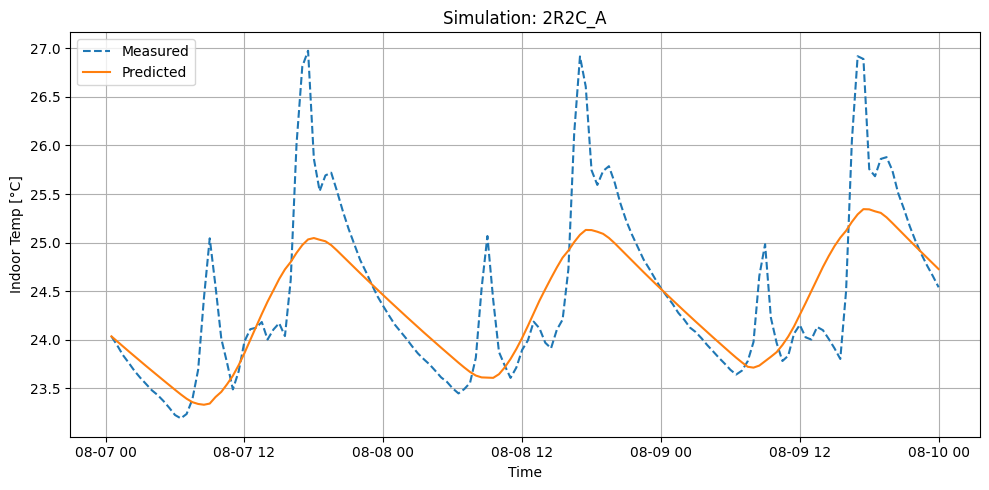


=== Best result ===
Best Trial Validation #: 21
Best Trial Training #: 11
Best RMSE Validation: 0.6125
RMSE Training of Best Validation : 0.2584
Best RMSE Training: 0.2222
Best initialization Validation: {'R_e_a': 0.9155007852652367, 'R_in_e': 0.762172441367354, 'C_in': 253052662.31625918, 'C_e': 494196912.794064, 'Ain': 7.956780507287012, 'Ae': 0.996808669195886, 'fh': 0.2622743218149849}
Best initialization Training: {'R_e_a': 0.9800254577336202, 'R_in_e': 0.5966623166574694, 'C_in': 355158805.3157091, 'C_e': 4671556.983081853, 'Ain': 8.861799814588922, 'Ae': 0.6427025151363015, 'fh': 0.569230212091448}
Best parameters Validation: {'R_in_e': 0.0227001846040138, 'R_e_a': 0.005077779117388757, 'C_in': 1130942.6847587351, 'C_e': 326198476.5265176, 'Ain': 0.3692810904084926, 'Ae': 8.545874654546772, 'fh': 0.12575309561609493, 'Objective': 0.258423697220192, 'Solve_time': 0.16207408905029297}
Best parameters Training: {'R_in_e': 0.0013584482708318966, 'R_e_a': 0.035476456571041384, 'C_in

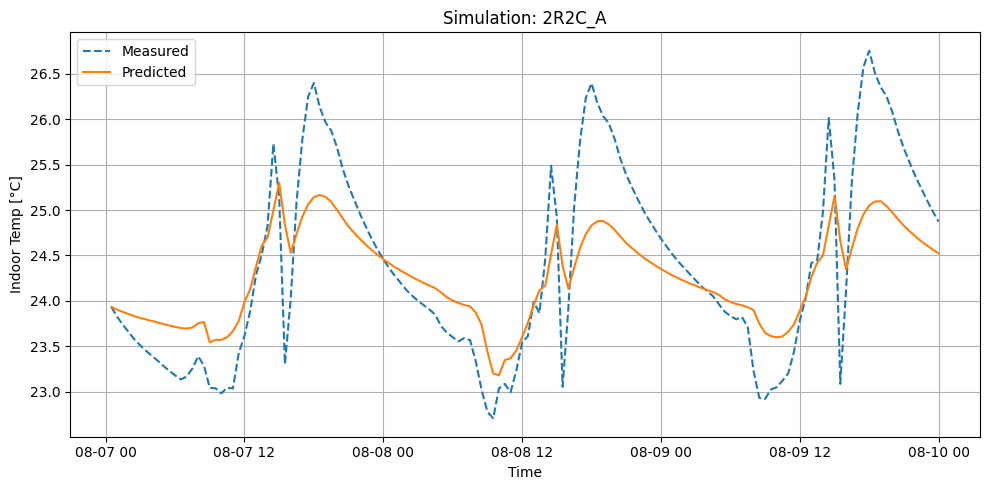

In [35]:
# --- Bounds ---
bounds_cs1 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.001, 0.3 * cs1_surface_area),
    "Ae": (0.001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
bounds_cs2 = {
    "R_e_a": (0.0005, 1),
    "R_in_e": (0.0005, 1),
    "C_in": (1e6, 1e10),
    "C_e": (1e6, 1e10),
    "Ain": (0.001, 0.3 * cs2_surface_area),
    "Ae": (0.001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}
bounds_cs3 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (5e6, 5e8),
    "C_e": (5e6, 5e8),
    "Ain": (0.001, 0.3 * cs3_surface_area),
    "Ae": (0.001, 0.3 * cs3_surface_area),
    "fh": (0,1)
}
bounds_cs4 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.001, 0.3 * cs4_surface_area),
    "Ae": (0.001, 0.3 * cs4_surface_area),
    "fh": (0,1)
}

###################### ======================== Case Study 1 ======================= ###########################

model_2r2c_cs1, parameters_2r2c_cs1, best_initialization,validation_pred_2r2c_cs1, initialize_testing_2r2c_cs1, all_trials_2r2c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="2R2C_A", bounds=bounds_cs1, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_2r2c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_2r2c_cs1, testing_df_2r2c_cs1 = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters, model_type="2R2C_A",
        initializations=initialize_testing_2r2c_cs1, show_plot=True
    )

###################### ======================== Case Study 2 ======================= ###########################

model_2r2c_cs2, parameters_2r2c_cs2, best_initialization_2r2c_cs2,validation_pred_2r2c_cs2, initialize_testing_2r2c_cs2, all_trials_2r2c_cs2 = train_greybox_model_with_validation_process(
    train_df=train_cs2, val_df=val_cs2, model_type="2R2C_A", bounds=bounds_cs2, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_2r2c_cs2['Tin'] = test_cs2['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_2r2c_cs2, testing_df_2r2c_cs2 = simulate_and_evaluate(
        val_df=test_cs2, param_dict=parameters_2r2c_cs2, model_type="2R2C_A",
        initializations=initialize_testing_2r2c_cs2, show_plot=True
    )

###################### ======================== Case Study 3 ======================= ###########################

model_2r2c_cs3, parameters_2r2c_cs3, best_initialization_2r2c_cs3,validation_pred_2r2c_cs3, initialize_testing_2r2c_cs3, all_trials_2r2c_cs3 = train_greybox_model_with_validation_process(
    train_df=train_cs3, val_df=val_cs3, model_type="2R2C_A", bounds=bounds_cs3, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_2r2c_cs3['Tin'] = test_cs3['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_2r2c_cs3, testing_df_2r2c_cs3 = simulate_and_evaluate(
        val_df=test_cs3, param_dict=parameters_2r2c_cs3, model_type="2R2C_A",
        initializations=initialize_testing_2r2c_cs3, show_plot=True
    )

###################### ======================== Case Study 4 ======================= ###########################

model_2r2c_cs4, parameters_2r2c_cs4, best_initialization_2r2c_cs4,validation_pred_2r2c_cs4, initialize_testing_2r2c_cs4, all_trials_2r2c_cs4 = train_greybox_model_with_validation_process(
    train_df=train_cs4, val_df=val_cs4, model_type="2R2C_A", bounds=bounds_cs4, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_2r2c_cs4['Tin'] = test_cs4['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_2r2c_cs4, testing_df_2r2c_cs4 = simulate_and_evaluate(
        val_df=test_cs4, param_dict=parameters_2r2c_cs4, model_type="2R2C_A",
        initializations=initialize_testing_2r2c_cs4, show_plot=True
    )


=== Best result ===
Best Trial Validation #: 24
Best Trial Training #: 0
Best RMSE Validation: 0.1850
RMSE Training of Best Validation : 0.0109
Best RMSE Training: 0.0109
Best initialization Validation: {'R_in_e': 0.5952525321224077, 'R_e_a': 0.7391278104558996, 'R_in_a': 0.03341100260113978, 'C_in': 329700101.7247841, 'C_e': 266613646.09977576, 'Ain': 3.0980399397505654, 'Ae': 5.175799056003167, 'fh': 0.5679742973160805}
Best initialization Training: {'R_in_e': 0.14208231982977632, 'R_e_a': 0.5713065394226368, 'R_in_a': 0.18608508502794038, 'C_in': 140042888.49440315, 'C_e': 110136190.36146803, 'Ain': 5.485215112286526, 'Ae': 24.771345975724852, 'fh': 0.28570756766089034}
Best parameters Validation: {'R_in_e': 0.006569076363509529, 'R_e_a': 0.01950857947406467, 'R_in_a': 0.04925110006780158, 'C_in': 4530463.710010188, 'C_e': 19944559.21999819, 'Ain': 0.928092587695457, 'Ae': 1.2547322949652107, 'fh': 0.24551634793766317, 'Objective': 0.01086347574847738, 'Solve_time': 0.6075189113616

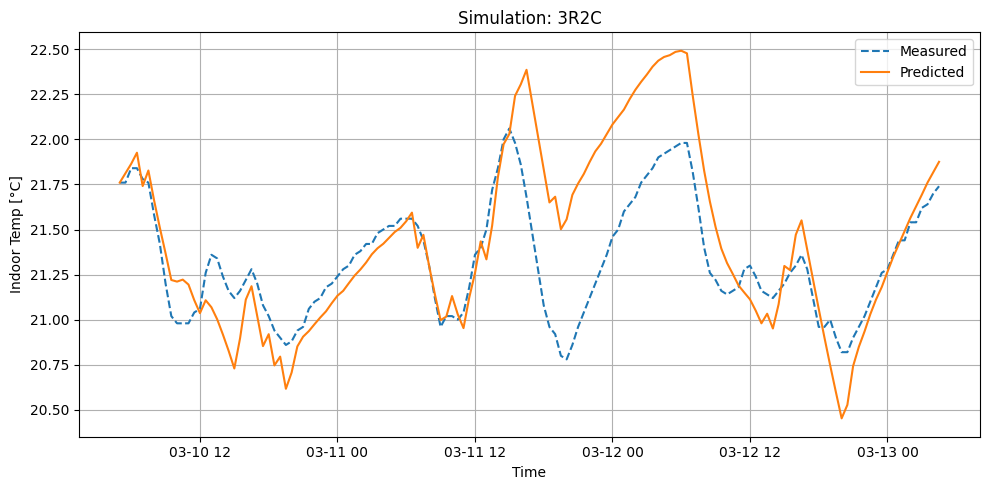


=== Best result ===
Best Trial Validation #: 16
Best Trial Training #: 26
Best RMSE Validation: 1.5183
RMSE Training of Best Validation : 0.2655
Best RMSE Training: 0.2655
Best initialization Validation: {'R_in_e': 0.5887638687621701, 'R_e_a': 0.39828673001862164, 'R_in_a': 0.9738266129437924, 'C_in': 272555132.5893474, 'C_e': 138344351.33746713, 'Ain': 446.94651377551764, 'Ae': 171.04003445270789, 'fh': 0.9042432914075651}
Best initialization Training: {'R_in_e': 0.850723953487101, 'R_e_a': 0.20232684962830655, 'R_in_a': 0.934498605714688, 'C_in': 344854739.2203666, 'C_e': 411813333.1273351, 'Ain': 350.40018073783807, 'Ae': 491.09554394548985, 'fh': 0.01620039733946721}
Best parameters Validation: {'R_in_e': 0.01529627511770756, 'R_e_a': 0.9996474272302582, 'R_in_a': 0.001473910740117336, 'C_in': 499999757.20181453, 'C_e': 499999908.1565709, 'Ain': 136.11500524264093, 'Ae': 0.0004159273114936854, 'fh': 0.31703041779635366, 'Objective': 0.2655056636293268, 'Solve_time': 0.136464834213

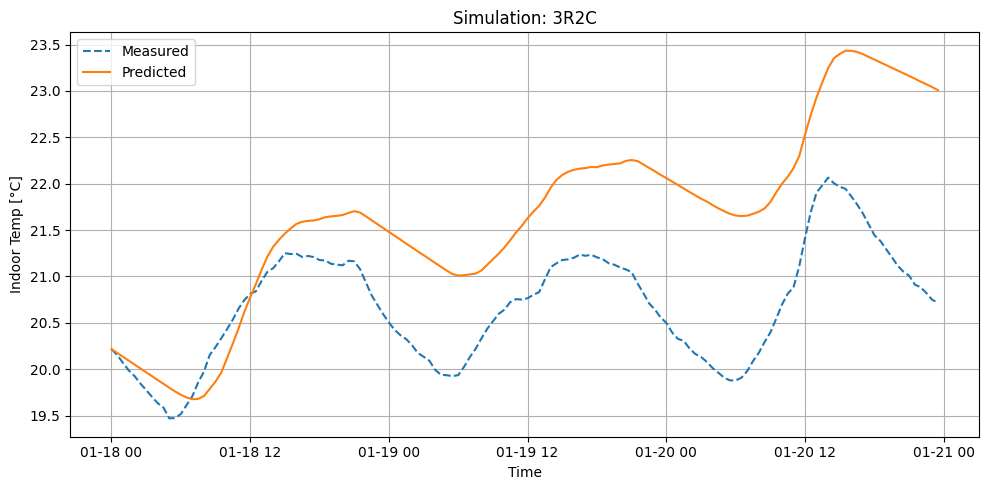


=== Best result ===
Best Trial Validation #: 6
Best Trial Training #: 28
Best RMSE Validation: 0.8621
RMSE Training of Best Validation : 0.4205
Best RMSE Training: 0.3853
Best initialization Validation: {'R_in_e': 0.29652827339903953, 'R_e_a': 0.00211098210199122, 'R_in_a': 0.27268260483880047, 'C_in': 109727798.43374525, 'C_e': 331255457.9718851, 'Ain': 10.836504984830569, 'Ae': 10.148230298112505, 'fh': 0.0162434432094537}
Best initialization Training: {'R_in_e': 0.8286102322680519, 'R_e_a': 0.08110657005530118, 'R_in_a': 0.47736203885539125, 'C_in': 315416470.30397004, 'C_e': 414497800.15302634, 'Ain': 13.397351129886472, 'Ae': 4.737956463174162, 'fh': 0.9408801695592043}
Best parameters Validation: {'R_in_e': 0.00635287485846131, 'R_e_a': 0.003689837255105414, 'R_in_a': 0.03867894915666234, 'C_in': 1003492.5664605465, 'C_e': 344981176.91154283, 'Ain': 0.7354085231025017, 'Ae': 13.827276304842828, 'fh': 0.35898456903720233, 'Objective': 0.42052849098025313, 'Solve_time': 5.18249702

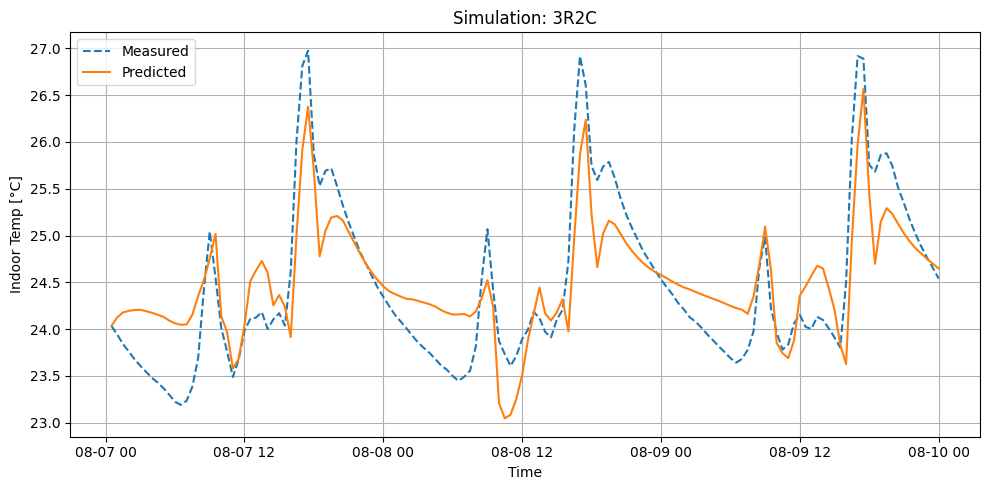


=== Best result ===
Best Trial Validation #: 19
Best Trial Training #: 5
Best RMSE Validation: 0.5590
RMSE Training of Best Validation : 0.2318
Best RMSE Training: 0.2221
Best initialization Validation: {'R_in_e': 0.20910707461850944, 'R_e_a': 0.3560838980266977, 'R_in_a': 0.6695498108949418, 'C_in': 242417467.39046296, 'C_e': 209776377.15578842, 'Ain': 6.118636582513707, 'Ae': 10.153689428169837, 'fh': 0.575593428640082}
Best initialization Training: {'R_in_e': 0.06052751025579057, 'R_e_a': 0.6047549603950563, 'R_in_a': 0.7639285770809702, 'C_in': 262177284.0900821, 'C_e': 114159540.0345032, 'Ain': 11.397559149253226, 'Ae': 1.3698999144515374, 'fh': 0.4418337048019546}
Best parameters Validation: {'R_in_e': 0.004741647869183835, 'R_e_a': 0.9999943677718945, 'R_in_a': 0.03495483530909715, 'C_in': 3199360.6029927824, 'C_e': 37905986.485394515, 'Ain': 1.0233854808583132, 'Ae': 2.4549096597629285, 'fh': 0.43356678571492285, 'Objective': 0.23181128494796976, 'Solve_time': 0.79324007034301

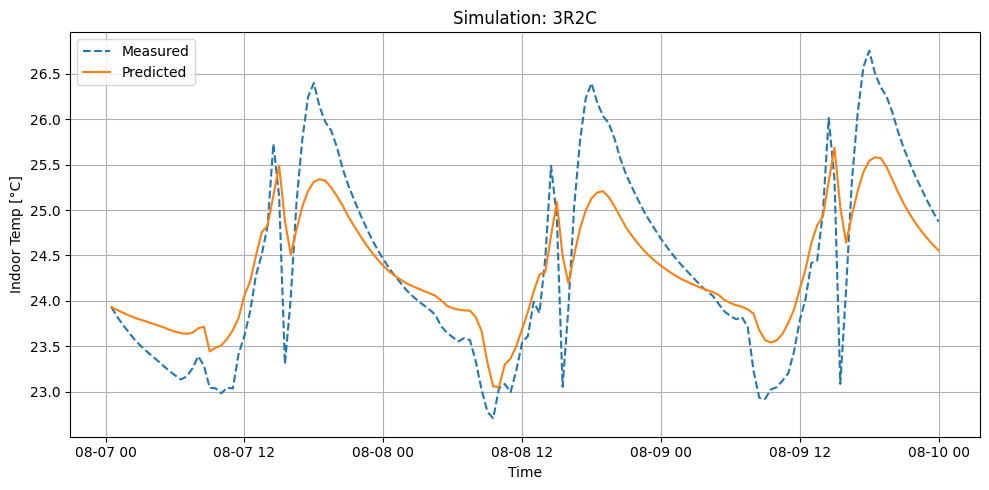

In [23]:
# --- Bounds ---
bounds_cs1 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
bounds_cs2 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}
bounds_cs3 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs3_surface_area),
    "Ae": (0.0001, 0.3 * cs3_surface_area),
    "fh": (0,1)
}
bounds_cs4 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs4_surface_area),
    "Ae": (0.0001, 0.3 * cs4_surface_area),
    "fh": (0,1)
}

###################### ======================== Case Study 1 ======================= ###########################

model_3r2c_cs1, parameters_3r2c_cs1, best_initialization_3r2c_cs1, validation_pred_3r2c_cs1, initialize_testing_3r2c_cs1, all_trials_3r2c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="3R2C", bounds=bounds_cs1, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_3r2c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_3r2c_cs1, testing_df_3r2c_cs1 = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_3r2c_cs1, model_type="3R2C",
        initializations=initialize_testing_3r2c_cs1, show_plot=True
    )

###################### ======================== Case Study 2 ======================= ###########################

model_3r2c_cs2, parameters_3r2c_cs2, best_initialization_3r2c_cs2, validation_pred_3r2c_cs2, initialize_testing_3r2c_cs2, all_trials_3r2c_cs2 = train_greybox_model_with_validation_process(
    train_df=train_cs2, val_df=val_cs2, model_type="3R2C", bounds=bounds_cs2, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_3r2c_cs2['Tin'] = test_cs2['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_3r2c_cs2, testing_df_3r2c_cs2= simulate_and_evaluate(
        val_df=test_cs2, param_dict=parameters_3r2c_cs2, model_type="3R2C",
        initializations=initialize_testing_3r2c_cs2, show_plot=True
    )

###################### ======================== Case Study 3 ======================= ###########################

model_3r2c_cs3, parameters_3r2c_cs3, best_initialization_3r2c_cs3, validation_pred_3r2c_cs3, initialize_testing_3r2c_cs3, all_trials_3r2c_cs3 = train_greybox_model_with_validation_process(
    train_df=train_cs3, val_df=val_cs3, model_type="3R2C", bounds=bounds_cs3, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_3r2c_cs3['Tin'] = test_cs3['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_3r2c_cs2, testing_df_3r2c_cs3= simulate_and_evaluate(
        val_df=test_cs3, param_dict=parameters_3r2c_cs3, model_type="3R2C",
        initializations=initialize_testing_3r2c_cs3, show_plot=True
    )

###################### ======================== Case Study 4 ======================= ###########################

model_3r2c_cs4, parameters_3r2c_cs4, best_initialization_3r2c_cs4, validation_pred_3r2c_cs4, initialize_testing_3r2c_cs4, all_trials_3r2c_cs4 = train_greybox_model_with_validation_process(
    train_df=train_cs4, val_df=val_cs4, model_type="3R2C", bounds=bounds_cs4, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_3r2c_cs4['Tin'] = test_cs4['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_3r2c_cs4, testing_df_3r2c_cs4 = simulate_and_evaluate(
        val_df=test_cs4, param_dict=parameters_3r2c_cs4, model_type="3R2C",
        initializations=initialize_testing_3r2c_cs4, show_plot=True
    )


=== Best result ===
Best Trial Validation #: 16
Best Trial Training #: 18
Best RMSE Validation: 0.1826
RMSE Training of Best Validation : 0.0104
Best RMSE Training: 0.0096
Best initialization Validation: {'R_int_in': 0.5997805511608562, 'R_in_e': 0.1167031310654477, 'R_e_a': 0.0956695702537095, 'R_in_a': 0.9098075657977193, 'C_int': 334997091.15351355, 'C_in': 414848255.49919766, 'C_e': 439634675.4607949, 'Aint': 17.15321338421446, 'Ain': 15.523438808016063, 'Ae': 12.912879266888673, 'fh_int': 0.3169465877911193, 'fh_in': 0.43459596085871177, 'fh_e': 0.7738796557301564}
Best initialization Training: {'R_int_in': 0.9506299904810311, 'R_in_e': 0.6014497644152592, 'R_e_a': 0.7441067283442067, 'R_in_a': 0.5072535273762123, 'C_int': 317491090.85051405, 'C_in': 36580989.40752619, 'C_e': 128090520.52391328, 'Aint': 10.855656610844841, 'Ain': 14.174853400859906, 'Ae': 1.369557800196962, 'fh_int': 0.14002409755331768, 'fh_in': 0.2768143077913058, 'fh_e': 0.9715326909010507}
Best parameters Val

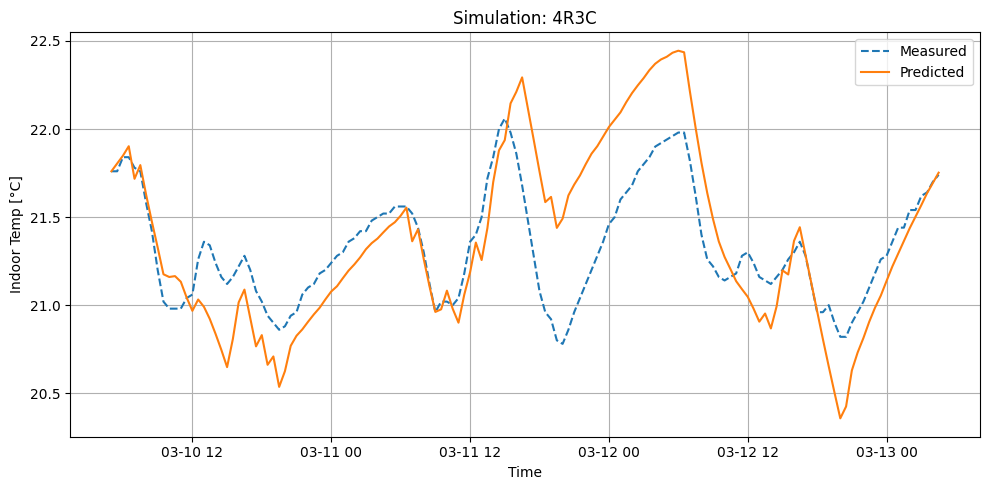


=== Best result ===
Best Trial Validation #: 18
Best Trial Training #: 14
Best RMSE Validation: 0.4804
RMSE Training of Best Validation : 0.2033
Best RMSE Training: 0.0719
Best initialization Validation: {'R_int_in': 0.6085366180082171, 'R_in_e': 0.2967108746166891, 'R_e_a': 0.13832770184387028, 'R_in_a': 0.652336480956322, 'C_int': 369612412.11640656, 'C_in': 158634919.06915897, 'C_e': 322842502.8863301, 'Aint': 248.9325322821563, 'Ain': 449.3203651473608, 'Ae': 125.50570326172597, 'fh_int': 0.8902150026361744, 'fh_in': 0.28740959646557973, 'fh_e': 0.3677859877561529}
Best initialization Training: {'R_int_in': 0.24833022146349845, 'R_in_e': 0.7414222480397673, 'R_e_a': 0.31763760942984814, 'R_in_a': 0.1036886032898815, 'C_int': 180884678.6976534, 'C_in': 136072171.24860135, 'C_e': 421544696.7976848, 'Aint': 197.40925674384843, 'Ain': 497.0274783256374, 'Ae': 561.8794620435484, 'fh_int': 0.43381741957652953, 'fh_in': 0.909943143854392, 'fh_e': 0.37731805396319285}
Best parameters Vali

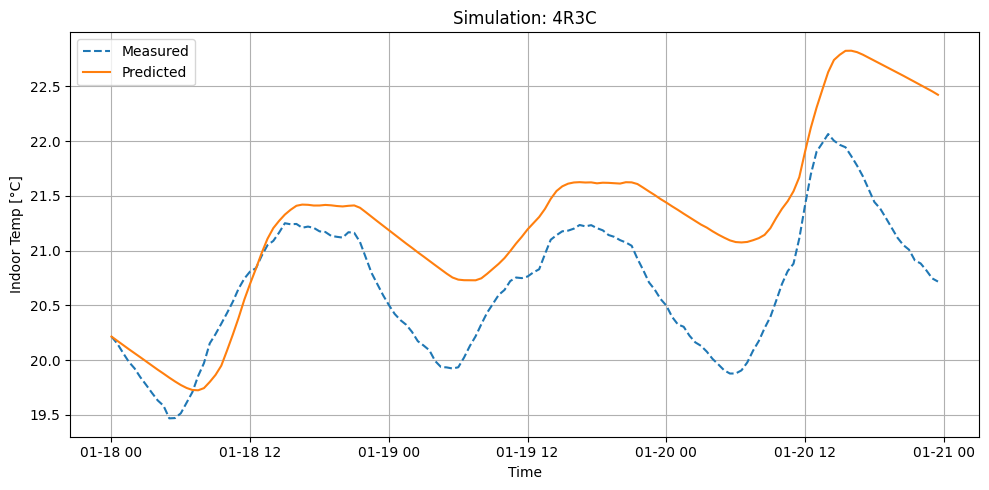


=== Best result ===
Best Trial Validation #: 13
Best Trial Training #: 5
Best RMSE Validation: 0.8160
RMSE Training of Best Validation : 0.3488
Best RMSE Training: 0.3415
Best initialization Validation: {'R_int_in': 0.8629151902068806, 'R_in_e': 0.18089710068397447, 'R_e_a': 0.8004034748001541, 'R_in_a': 0.5536016615671082, 'C_int': 199000976.57659364, 'C_in': 66899456.25525187, 'C_e': 432809524.5437655, 'Aint': 2.6894561325523143, 'Ain': 5.2974414136896755, 'Ae': 4.959849592004473, 'fh_int': 0.8714140341908543, 'fh_in': 0.672702994208898, 'fh_e': 0.7966813971913723}
Best initialization Training: {'R_int_in': 0.9409029514621017, 'R_in_e': 0.5079065970859109, 'R_e_a': 0.4105932476733843, 'R_in_a': 0.8112568238459026, 'C_int': 418109972.8417654, 'C_in': 166896887.3180636, 'C_e': 347176687.0679291, 'Aint': 13.186223038785673, 'Ain': 11.194561280339133, 'Ae': 2.5923606195742193, 'fh_int': 0.875883083517057, 'fh_in': 0.5390945527360087, 'fh_e': 0.2824724263700037}
Best parameters Validatio

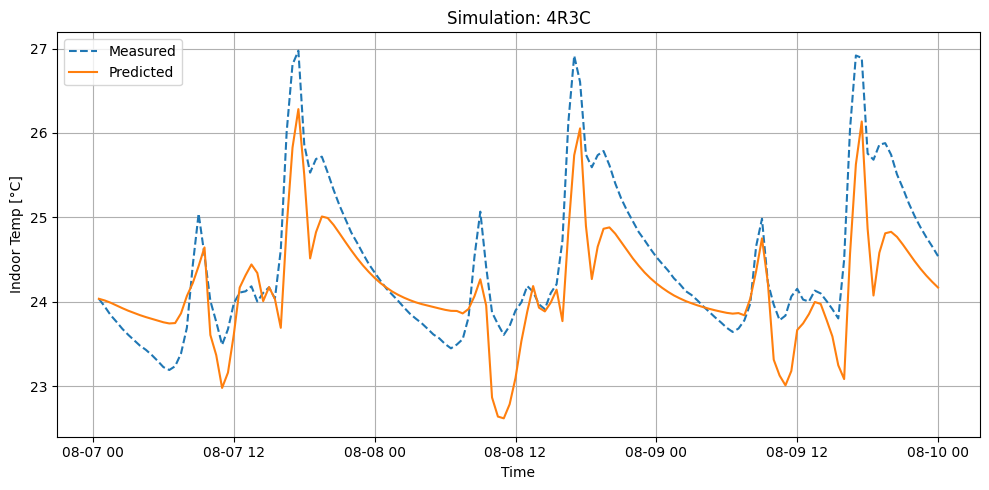


=== Best result ===
Best Trial Validation #: 0
Best Trial Training #: 2
Best RMSE Validation: 0.5118
RMSE Training of Best Validation : 0.2033
Best RMSE Training: 0.1947
Best initialization Validation: {'R_int_in': 0.16204467530750366, 'R_in_e': 0.6742981266399579, 'R_e_a': 0.1808947492278022, 'R_in_a': 0.6945616913291365, 'C_int': 115723562.58407956, 'C_in': 59834588.51492972, 'C_e': 83643903.68330717, 'Aint': 0.03416531303257967, 'Ain': 12.29047559133358, 'Ae': 12.524084698793375, 'fh_int': 0.5149333499132595, 'fh_in': 0.1613628010553837, 'fh_e': 0.08355433751068975}
Best initialization Training: {'R_int_in': 0.22111481538334235, 'R_in_e': 0.9599430771080284, 'R_e_a': 0.6170678849538727, 'R_in_a': 0.5577646862857517, 'C_int': 208588621.63743296, 'C_in': 215157433.51495597, 'C_e': 271003415.91443473, 'Aint': 11.908980057336729, 'Ain': 12.006728030099664, 'Ae': 2.936048652372417, 'fh_int': 0.500112752076627, 'fh_in': 0.41195809503410197, 'fh_e': 0.8705269662693842}
Best parameters Val

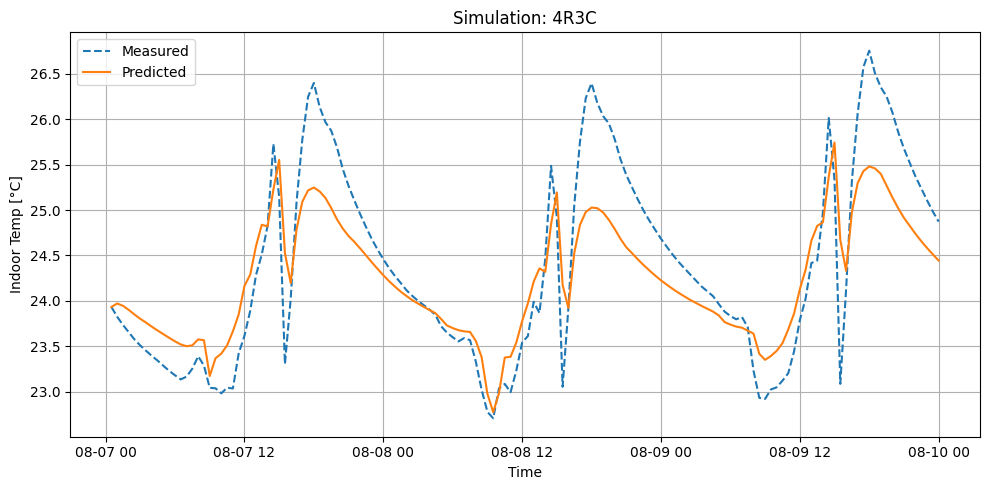

In [15]:
# --- Bounds ---
bounds_cs1 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs1_surface_area),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}
bounds_cs2 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs2_surface_area),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}
bounds_cs3 = {
   "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs3_surface_area),
    "Ain": (0.0001, 0.3 * cs3_surface_area),
    "Ae": (0.0001, 0.3 * cs3_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}
bounds_cs4 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs4_surface_area),
    "Ain": (0.0001, 0.3 * cs4_surface_area),
    "Ae": (0.0001, 0.3 * cs4_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}

###################### ======================== Case Study 1 ======================= ###########################

model_4r3c_cs1, parameters_4r3c_cs1, best_initialization_4r3c_cs1, validation_pred_4r3c_cs1, initialize_testing_4r3c_cs1, all_trials_4r3c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="4R3C", bounds=bounds_cs1, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_4r3c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_4r3c_cs1, testing_df_4r3c_cs1 = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_4r3c_cs1, model_type="4R3C",
        initializations=initialize_testing_4r3c_cs1, show_plot=True
    )

###################### ======================== Case Study 2 ======================= ###########################

model_4r3c_cs2, parameters_4r3c_cs2, best_initialization_4r3c_cs2, validation_pred_4r3c_cs2, initialize_testing_4r3c_cs2, all_trials_4r3c_cs2 = train_greybox_model_with_validation_process(
    train_df=train_cs2, val_df=val_cs2, model_type="4R3C", bounds=bounds_cs2, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_4r3c_cs2['Tin'] = test_cs2['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_4r3c_cs2, testing_df_4r3c_cs2 = simulate_and_evaluate(
        val_df=test_cs2, param_dict=parameters_4r3c_cs2, model_type="4R3C",
        initializations=initialize_testing_4r3c_cs2, show_plot=True
    )

###################### ======================== Case Study 3 ======================= ###########################

model_4r3c_cs3, parameters_4r3c_cs3, best_initialization_4r3c_cs3, validation_pred_4r3c_cs3, initialize_testing_4r3c_cs3, all_trials_4r3c_cs3 = train_greybox_model_with_validation_process(
    train_df=train_cs3, val_df=val_cs3, model_type="4R3C", bounds=bounds_cs3, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_4r3c_cs3['Tin'] = test_cs3['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_4r3c_cs3, testing_df_4r3c_cs3 = simulate_and_evaluate(
        val_df=test_cs3, param_dict=parameters_4r3c_cs3, model_type="4R3C",
        initializations=initialize_testing_4r3c_cs3, show_plot=True
    )

###################### ======================== Case Study 4 ======================= ###########################

model_4r3c_cs4, parameters_4r3c_cs4, best_initialization_4r3c_cs4, validation_pred_4r3c_cs4, initialize_testing_4r3c_cs4, all_trials_4r3c_cs4 = train_greybox_model_with_validation_process(
    train_df=train_cs4, val_df=val_cs4, model_type="4R3C", bounds=bounds_cs4, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_4r3c_cs4['Tin'] = test_cs4['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_4r3c_cs4, testing_df_4r3c_cs4 = simulate_and_evaluate(
        val_df=test_cs4, param_dict=parameters_4r3c_cs4, model_type="4R3C",
        initializations=initialize_testing_4r3c_cs4, show_plot=True
    )


RMSE 1R1C Case Study 1: 0.15 °C
RMSE 2R2C Case Study 1: 0.18 °C
RMSE 3R2C Case Study 1: 0.10 °C
RMSE 4R3C Case Study 1: 0.10 °C
RMSE 1R1C Case Study 2: 0.87 °C
RMSE 2R2C Case Study 2: 0.89 °C
RMSE 3R2C Case Study 2: 0.52 °C
RMSE 4R3C Case Study 2: 0.45 °C
RMSE 1R1C Case Study 3: 1.16 °C
RMSE 2R2C Case Study 3: 0.76 °C
RMSE 3R2C Case Study 3: 0.65 °C
RMSE 4R3C Case Study 3: 0.59 °C
RMSE 1R1C Case Study 4: 0.75 °C
RMSE 2R2C Case Study 4: 0.51 °C
RMSE 3R2C Case Study 4: 0.48 °C
RMSE 4R3C Case Study 4: 0.45 °C


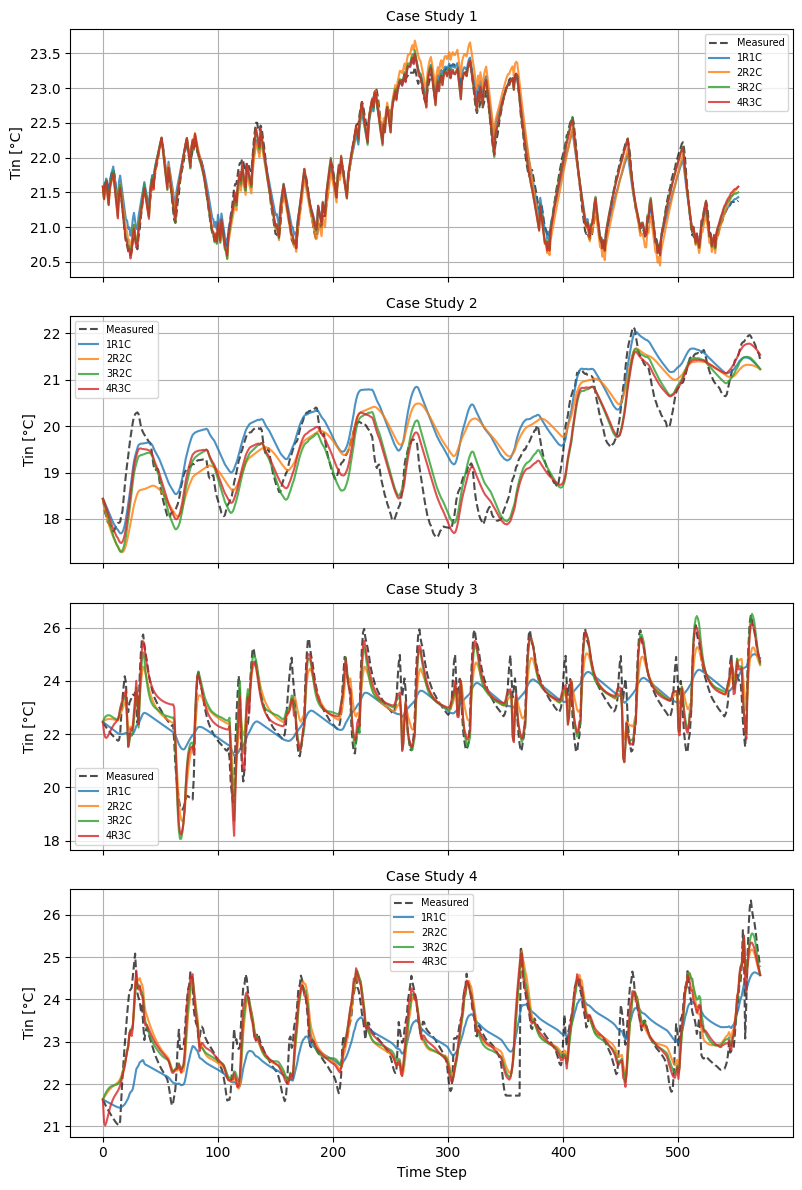

In [16]:
T_model_1r1c_cs1 = np.array([model_1r1c_cs1.T_in[t]() for t in model_1r1c_cs1.T_in.index_set()])
T_model_2r2c_cs1 = np.array([model_2r2c_cs1.T_in[t]() for t in model_2r2c_cs1.T_in.index_set()])
T_model_3r2c_cs1 = np.array([model_3r2c_cs1.T_in[t]() for t in model_3r2c_cs1.T_in.index_set()])
T_model_4r3c_cs1 = np.array([model_4r3c_cs1.T_in[t]() for t in model_4r3c_cs1.T_in.index_set()])

T_model_1r1c_cs2 = np.array([model_1r1c_cs2.T_in[t]() for t in model_1r1c_cs2.T_in.index_set()])
T_model_2r2c_cs2 = np.array([model_2r2c_cs2.T_in[t]() for t in model_2r2c_cs2.T_in.index_set()])
T_model_3r2c_cs2 = np.array([model_3r2c_cs2.T_in[t]() for t in model_3r2c_cs2.T_in.index_set()])
T_model_4r3c_cs2 = np.array([model_4r3c_cs2.T_in[t]() for t in model_4r3c_cs2.T_in.index_set()])

T_model_1r1c_cs3 = np.array([model_1r1c_cs3.T_in[t]() for t in model_1r1c_cs3.T_in.index_set()])
T_model_2r2c_cs3 = np.array([model_2r2c_cs3.T_in[t]() for t in model_2r2c_cs3.T_in.index_set()])
T_model_3r2c_cs3 = np.array([model_3r2c_cs3.T_in[t]() for t in model_3r2c_cs3.T_in.index_set()])
T_model_4r3c_cs3 = np.array([model_4r3c_cs3.T_in[t]() for t in model_4r3c_cs3.T_in.index_set()])

T_model_1r1c_cs4 = np.array([model_1r1c_cs4.T_in[t]() for t in model_1r1c_cs4.T_in.index_set()])
T_model_2r2c_cs4 = np.array([model_2r2c_cs4.T_in[t]() for t in model_2r2c_cs4.T_in.index_set()])
T_model_3r2c_cs4 = np.array([model_3r2c_cs4.T_in[t]() for t in model_3r2c_cs4.T_in.index_set()])
T_model_4r3c_cs4 = np.array([model_4r3c_cs4.T_in[t]() for t in model_4r3c_cs4.T_in.index_set()])


datasets=[train_cs1, train_cs2, train_cs3, train_cs4]
validation_dataset=[[T_model_1r1c_cs1,T_model_2r2c_cs1,T_model_3r2c_cs1, T_model_4r3c_cs1] ,
                    [T_model_1r1c_cs2,T_model_2r2c_cs2,T_model_3r2c_cs2, T_model_4r3c_cs2] , 
                    [T_model_1r1c_cs3,T_model_2r2c_cs3,T_model_3r2c_cs3, T_model_4r3c_cs3] , 
                    [T_model_1r1c_cs4,T_model_2r2c_cs4,T_model_3r2c_cs4, T_model_4r3c_cs4]]
labels = ['1R1C', '2R2C', '3R2C', '4R3C']
TC_labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
plot_model_validation(datasets,validation_dataset,labels,TC_labels, figsize=(8,12))

RMSE 1R1C Case Study 1: 0.28 °C
RMSE 2R2C Case Study 1: 0.22 °C
RMSE 3R2C Case Study 1: 0.18 °C
RMSE 4R3C Case Study 1: 0.18 °C
RMSE 1R1C Case Study 2: 1.34 °C
RMSE 2R2C Case Study 2: 1.37 °C
RMSE 3R2C Case Study 2: 1.52 °C
RMSE 4R3C Case Study 2: 0.48 °C
RMSE 1R1C Case Study 3: 1.06 °C
RMSE 2R2C Case Study 3: 0.91 °C
RMSE 3R2C Case Study 3: 0.86 °C
RMSE 4R3C Case Study 3: 0.82 °C
RMSE 1R1C Case Study 4: 1.34 °C
RMSE 2R2C Case Study 4: 0.60 °C
RMSE 3R2C Case Study 4: 0.52 °C
RMSE 4R3C Case Study 4: 0.51 °C


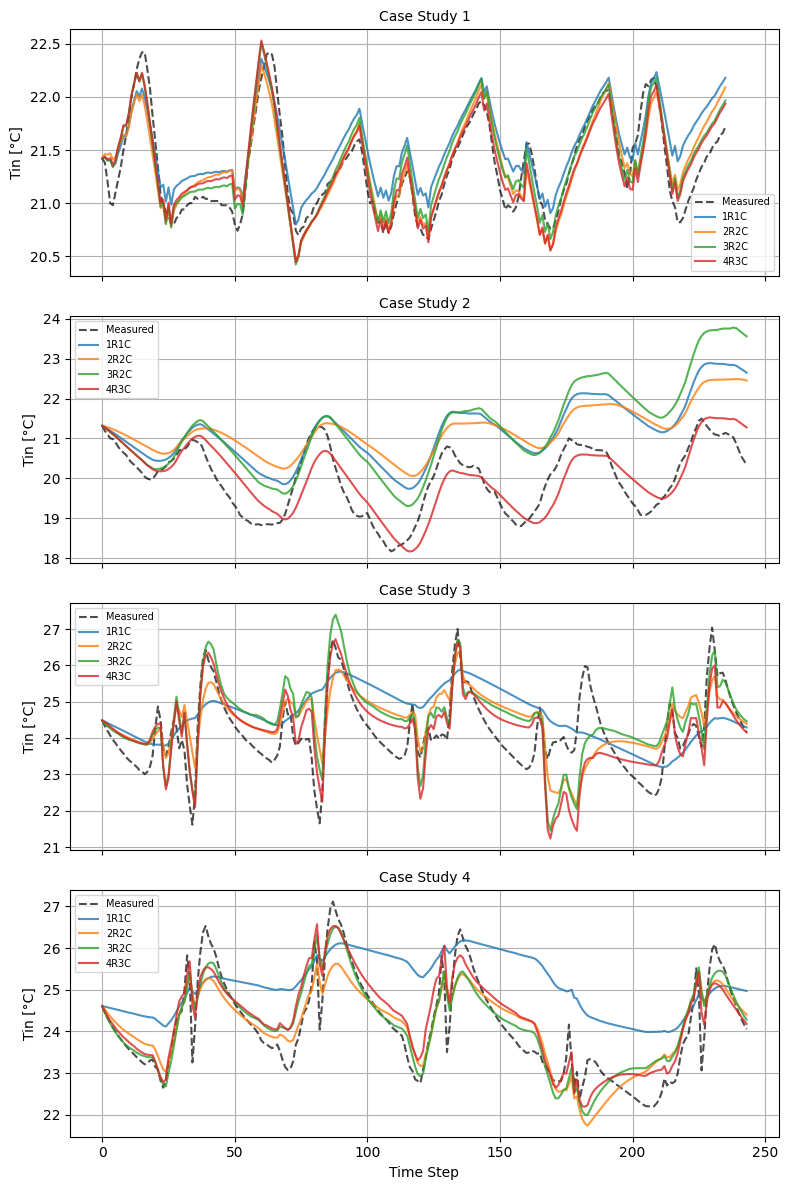

In [17]:
T_model_1r1c_cs1 = np.array(validation_pred_1r1c_cs1['T_in_estimate'])
T_model_2r2c_cs1 = np.array(validation_pred_2r2c_cs1['T_in_estimate'])
T_model_3r2c_cs1 = np.array(validation_pred_3r2c_cs1['T_in_estimate'])
T_model_4r3c_cs1 = np.array(validation_pred_4r3c_cs1['T_in_estimate'])

T_model_1r1c_cs2 = np.array(validation_pred_1r1c_cs2['T_in_estimate'])
T_model_2r2c_cs2 = np.array(validation_pred_2r2c_cs2['T_in_estimate'])
T_model_3r2c_cs2 = np.array(validation_pred_3r2c_cs2['T_in_estimate'])
T_model_4r3c_cs2 = np.array(validation_pred_4r3c_cs2['T_in_estimate'])

T_model_1r1c_cs3 = np.array(validation_pred_1r1c_cs3['T_in_estimate'])
T_model_2r2c_cs3 = np.array(validation_pred_2r2c_cs3['T_in_estimate'])
T_model_3r2c_cs3 = np.array(validation_pred_3r2c_cs3['T_in_estimate'])
T_model_4r3c_cs3 = np.array(validation_pred_4r3c_cs3['T_in_estimate'])

T_model_1r1c_cs4 = np.array(validation_pred_1r1c_cs4['T_in_estimate'])
T_model_2r2c_cs4 = np.array(validation_pred_2r2c_cs4['T_in_estimate'])
T_model_3r2c_cs4 = np.array(validation_pred_3r2c_cs4['T_in_estimate'])
T_model_4r3c_cs4 = np.array(validation_pred_4r3c_cs4['T_in_estimate'])
datasets=[val_cs1, val_cs2, val_cs3, val_cs4]
validation_dataset=[[T_model_1r1c_cs1,T_model_2r2c_cs1,T_model_3r2c_cs1, T_model_4r3c_cs1] ,
                    [T_model_1r1c_cs2,T_model_2r2c_cs2,T_model_3r2c_cs2, T_model_4r3c_cs2] , 
                    [T_model_1r1c_cs3,T_model_2r2c_cs3,T_model_3r2c_cs3, T_model_4r3c_cs3] , 
                    [T_model_1r1c_cs4,T_model_2r2c_cs4,T_model_3r2c_cs4, T_model_4r3c_cs4]]
labels = ['1R1C', '2R2C', '3R2C', '4R3C']
TC_labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
plot_model_validation(datasets,validation_dataset,labels, TC_labels, figsize=(8,12))

RMSE 1R1C Case Study 1: 0.36 °C
RMSE 2R2C Case Study 1: 0.37 °C
RMSE 3R2C Case Study 1: 0.33 °C
RMSE 4R3C Case Study 1: 0.32 °C
RMSE 1R1C Case Study 2: 0.34 °C
RMSE 2R2C Case Study 2: 0.41 °C
RMSE 3R2C Case Study 2: 1.17 °C
RMSE 4R3C Case Study 2: 0.75 °C
RMSE 1R1C Case Study 3: 0.67 °C
RMSE 2R2C Case Study 3: 0.56 °C
RMSE 3R2C Case Study 3: 0.49 °C
RMSE 4R3C Case Study 3: 0.58 °C
RMSE 1R1C Case Study 4: 0.82 °C
RMSE 2R2C Case Study 4: 0.63 °C
RMSE 3R2C Case Study 4: 0.55 °C
RMSE 4R3C Case Study 4: 0.56 °C


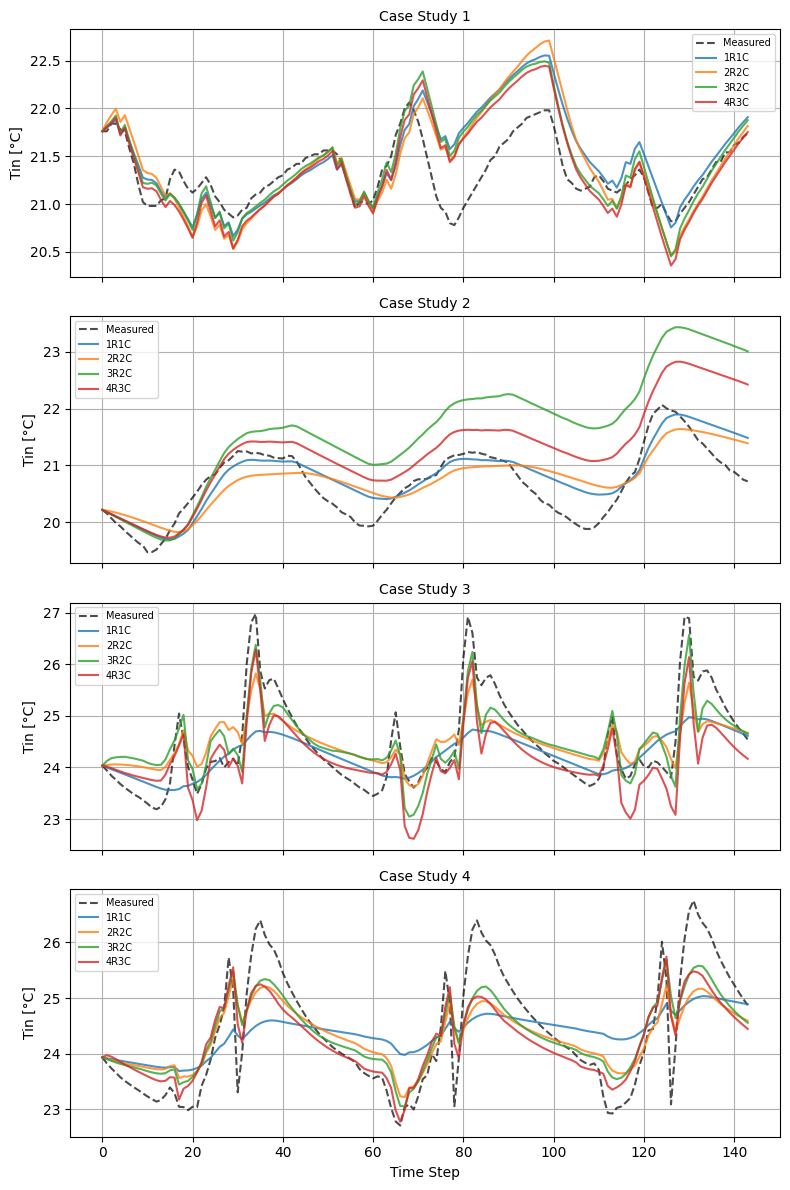

In [24]:
T_model_1r1c_cs1 = np.array(testing_df_1r1c_cs1['T_in_estimate'])
T_model_2r2c_cs1 = np.array(testing_df_2r2c_cs1['T_in_estimate'])
T_model_3r2c_cs1 = np.array(testing_df_3r2c_cs1['T_in_estimate'])
T_model_4r3c_cs1 = np.array(testing_df_4r3c_cs1['T_in_estimate'])

T_model_1r1c_cs2 = np.array(testing_df_1r1c_cs2['T_in_estimate'])
T_model_2r2c_cs2 = np.array(testing_df_2r2c_cs2['T_in_estimate'])
T_model_3r2c_cs2 = np.array(testing_df_3r2c_cs2['T_in_estimate'])
T_model_4r3c_cs2 = np.array(testing_df_4r3c_cs2['T_in_estimate'])

T_model_1r1c_cs3 = np.array(testing_df_1r1c_cs3['T_in_estimate'])
T_model_2r2c_cs3 = np.array(testing_df_2r2c_cs3['T_in_estimate'])
T_model_3r2c_cs3 = np.array(testing_df_3r2c_cs3['T_in_estimate'])
T_model_4r3c_cs3 = np.array(testing_df_4r3c_cs3['T_in_estimate'])

T_model_1r1c_cs4 = np.array(testing_df_1r1c_cs4['T_in_estimate'])
T_model_2r2c_cs4 = np.array(testing_df_2r2c_cs4['T_in_estimate'])
T_model_3r2c_cs4 = np.array(testing_df_3r2c_cs4['T_in_estimate'])
T_model_4r3c_cs4 = np.array(testing_df_4r3c_cs4['T_in_estimate'])
datasets=[test_cs1,test_cs2,test_cs3, test_cs4]
validation_dataset=[[T_model_1r1c_cs1,T_model_2r2c_cs1,T_model_3r2c_cs1, T_model_4r3c_cs1] ,
                    [T_model_1r1c_cs2,T_model_2r2c_cs2,T_model_3r2c_cs2, T_model_4r3c_cs2] , 
                    [T_model_1r1c_cs3,T_model_2r2c_cs3,T_model_3r2c_cs3, T_model_4r3c_cs3] , 
                    [T_model_1r1c_cs4,T_model_2r2c_cs4,T_model_3r2c_cs4, T_model_4r3c_cs4]]
labels = ['1R1C', '2R2C', '3R2C', '4R3C']
TC_labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']

plot_model_validation(datasets,validation_dataset,labels, TC_labels, figsize=(8,12))

## Computantional Time ##

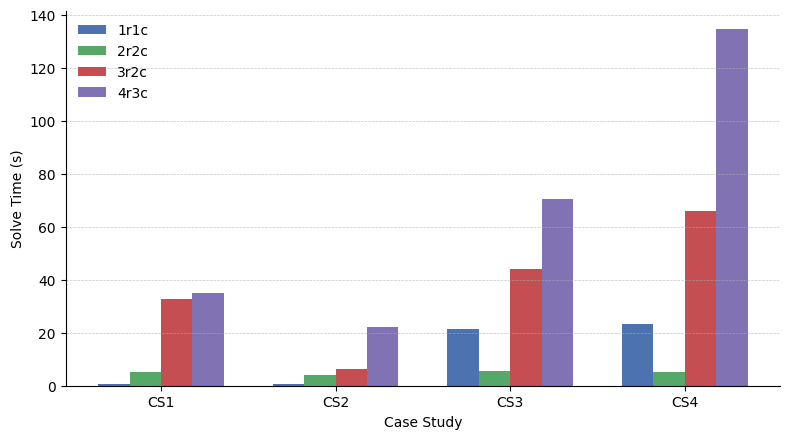

In [25]:
cases = ['CS1','CS2', 'CS3', 'CS4']
models = ['1r1c', '2r2c', '3r2c', '4r3c']
solve_times = {
    '1r1c': [
        all_trials_1r1c_cs1['Solve_time'].sum(),
        all_trials_1r1c_cs2['Solve_time'].sum(),
        all_trials_1r1c_cs3['Solve_time'].sum(),
        all_trials_1r1c_cs4['Solve_time'].sum()
    ],
    '2r2c': [
        all_trials_2r2c_cs1['Solve_time'].sum(),
        all_trials_2r2c_cs2['Solve_time'].sum(),
        all_trials_2r2c_cs3['Solve_time'].sum(),
        all_trials_2r2c_cs4['Solve_time'].sum()
    ],
    '3r2c': [
        all_trials_3r2c_cs1['Solve_time'].sum(),
        all_trials_3r2c_cs2['Solve_time'].sum(),
        all_trials_3r2c_cs3['Solve_time'].sum(),
        all_trials_3r2c_cs4['Solve_time'].sum()
    ],
    '4r3c': [
        all_trials_4r3c_cs1['Solve_time'].sum(),
        all_trials_4r3c_cs2['Solve_time'].sum(),
        all_trials_4r3c_cs3['Solve_time'].sum(),
        all_trials_4r3c_cs4['Solve_time'].sum()
    ],
}

x = np.arange(len(cases))
width = 0.18
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b3']

fig, ax = plt.subplots(figsize=(8, 4.5))

for i, model in enumerate(models):
    ax.bar(x + i * width, solve_times[model], width, label=model, color=colors[i])

ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(cases)
ax.set_ylabel("Solve Time (s)")
ax.set_xlabel("Case Study")
ax.legend(frameon=False)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

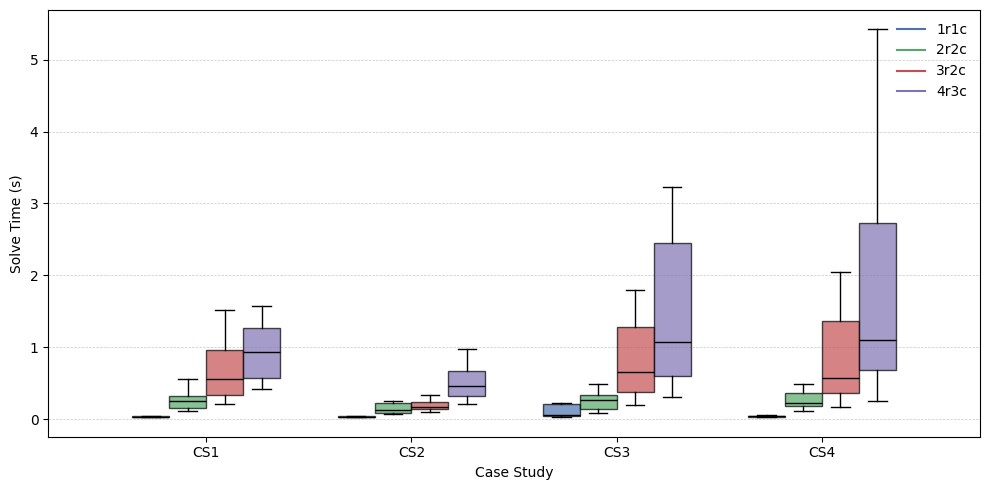

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

positions = []
data = []
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b3']
width = 0.18

# Prepare data and positions
for i, case in enumerate(cases):
    for j, model in enumerate(models):
        positions.append(i + j * width)
        # Use all_trials_XrXc_csY['Solve_time'] for each box
        if model == '1r1c':
            data.append(all_trials_1r1c_cs1['Solve_time'].values if i == 0 else
                        all_trials_1r1c_cs2['Solve_time'].values if i == 1 else
                        all_trials_1r1c_cs3['Solve_time'].values if i == 2 else
                        all_trials_1r1c_cs4['Solve_time'].values)
        elif model == '2r2c':
            data.append(all_trials_2r2c_cs1['Solve_time'].values if i == 0 else
                        all_trials_2r2c_cs2['Solve_time'].values if i == 1 else
                        all_trials_2r2c_cs3['Solve_time'].values if i == 2 else
                        all_trials_2r2c_cs4['Solve_time'].values)
        elif model == '3r2c':
            data.append(all_trials_3r2c_cs1['Solve_time'].values if i == 0 else
                        all_trials_3r2c_cs2['Solve_time'].values if i == 1 else
                        all_trials_3r2c_cs3['Solve_time'].values if i == 2 else
                        all_trials_3r2c_cs4['Solve_time'].values)
        elif model == '4r3c':
            data.append(all_trials_4r3c_cs1['Solve_time'].values if i == 0 else
                        all_trials_4r3c_cs2['Solve_time'].values if i == 1 else
                        all_trials_4r3c_cs3['Solve_time'].values if i == 2 else
                        all_trials_4r3c_cs4['Solve_time'].values)

# Plot each boxplot with its color
for j, model in enumerate(models):
    idx = [i * len(models) + j for i in range(len(cases))]
    bp = ax.boxplot([data[k] for k in idx],
                    positions=[positions[k] for k in idx],
                    widths=width,
                    patch_artist=True,
                    showfliers=False,
                    boxprops=dict(facecolor=colors[j], alpha=0.7),
                    medianprops=dict(color='black'))

# Set x-ticks at the center of each case group
group_centers = [i + 1.5 * width for i in range(len(cases))]
ax.set_xticks(group_centers)
ax.set_xticklabels(cases)

ax.set_ylabel("Solve Time (s)")
ax.set_xlabel("Case Study")
# ax.set_title("Solve Time Distribution by Case Study and Model Type")

# Add grid
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')

# Legend
for j, model in enumerate(models):
    ax.plot([], [], color=colors[j], label=model)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()


In [56]:
def latex_param_row(param_name, param_dicts, cases, fmt="{}"):
    vals = []
    for params in param_dicts:
        val = params.get(param_name, "-")
        if isinstance(val, float):
            val = fmt.format(val)
        vals.append(str(val))
    return " / ".join(vals)

# Collect parameter dictionaries for each model and case
params_1r1c = [parameters_1r1c_cs1, parameters_1r1c_cs2, parameters_1r1c_cs3, parameters_1r1c_cs4]
params_2r2c = [parameters_2r2c_cs1, parameters_2r2c_cs2, parameters_2r2c_cs3, parameters_2r2c_cs4]
params_3r2c = [parameters_3r2c_cs1, parameters_3r2c_cs2, parameters_3r2c_cs3, parameters_3r2c_cs4]
params_4r3c = [parameters_4r3c_cs1, parameters_4r3c_cs2, parameters_4r3c_cs3, parameters_4r3c_cs4]

# Example: print LaTeX row for R_in_a
print(f"$R_{{int,in}}$ & - & - & - & {latex_param_row('R_int_in', params_4r3c, cases, '{:.2g}')} \\\\ \\hline")
print(f"$R_{{in,e}}$ & - & {latex_param_row('R_in_e', params_2r2c, cases, '{:.2g}')} & {latex_param_row('R_in_e', params_3r2c, cases, '{:.2g}')} & {latex_param_row('R_in_e', params_4r3c, cases, '{:.2g}')} \\\\ \\hline")
print(f"$R_{{in,a}}$ & {latex_param_row('R_in_a', params_1r1c, cases, '{:.2g}')} & - & {latex_param_row('R_in_a', params_3r2c, cases, '{:.2g}')} & {latex_param_row('R_in_a', params_4r3c, cases, '{:.2g}')} \\\\ \\hline")
print(f"$R_{{e,a}}$ & - & {latex_param_row('R_e_a', params_2r2c, cases, '{:.2g}')} & {latex_param_row('R_e_a', params_3r2c, cases, '{:.2g}')} & {latex_param_row('R_e_a', params_4r3c, cases, '{:.2g}')} \\\\ \\hline")
print(f"$C_{{int}}$ & - & - & - & {latex_param_row('C_in', params_4r3c, cases, '{:.1e}')} \\\\ \\hline")
print(f"$C_{{in}}$ & {latex_param_row('C_in', params_1r1c, cases, '{:.1e}')} & {latex_param_row('C_in', params_2r2c, cases, '{:.1e}')} & {latex_param_row('C_in', params_3r2c, cases, '{:.1e}')} & {latex_param_row('C_in', params_4r3c, cases, '{:.1e}')} \\\\ \\hline")
print(f"$C_{{e}}$ & - & {latex_param_row('C_e', params_2r2c, cases, '{:.1e}')} & {latex_param_row('C_e', params_3r2c, cases, '{:.1e}')} & {latex_param_row('C_e', params_4r3c, cases, '{:.1e}')} \\\\ \\hline")
print(f"$A_{{int}}$ & - & - & - & {latex_param_row('Aint', params_4r3c, cases, '{:.2f}')} \\\\ \\hline")
print(f"$A_{{in}}$ & {latex_param_row('Ain', params_1r1c, cases, '{:.2f}')} & {latex_param_row('Ain', params_2r2c, cases, '{:.2f}')} & {latex_param_row('Ain', params_3r2c, cases, '{:.2f}')} & {latex_param_row('Ain', params_4r3c, cases, '{:.2f}')} \\\\ \\hline")
print(f"$A_{{e}}$ & - & {latex_param_row('Ae', params_2r2c, cases, '{:.2f}')} & {latex_param_row('Ae', params_3r2c, cases, '{:.2f}')} & {latex_param_row('Ae', params_4r3c, cases, '{:.2f}')} \\\\ \\hline")
print(f"$f_{{h,int}}$ & - & - & - & {latex_param_row('fh_int', params_4r3c, cases, '{:.2f}')} \\\\ \\hline")
print(f"$f_{{h,in}}$ & {latex_param_row('fh', params_1r1c, cases, '{:.2f}')} & {latex_param_row('fh', params_2r2c, cases, '{:.2f}')} & {latex_param_row('fh', params_3r2c, cases, '{:.2f}')} & {latex_param_row('fh_in', params_4r3c, cases, '{:.2f}')} \\\\ \\hline")
print(f"$f_{{h,e}}$ & - & - & - & {latex_param_row('fh_e', params_4r3c, cases, '{:.2f}')} \\\\ \\hline")

$R_{int,in}$ & - & - & - & 0.016 / 0.025 / 0.0043 / 0.0031 \\ \hline
$R_{in,e}$ & - & 0.048 / 0.0005 / 0.0016 / 0.023 & 0.0066 / 0.015 / 0.0064 / 0.0047 & 0.06 / 0.002 / 0.093 / 0.0027 \\ \hline
$R_{in,a}$ & 0.013 / 0.00043 / 0.012 / 0.072 & - & 0.049 / 0.0015 / 0.039 / 0.035 & 0.069 / 0.002 / 1 / 0.88 \\ \hline
$R_{e,a}$ & - & 0.0014 / 0.0005 / 0.001 / 0.0051 & 0.02 / 1 / 0.0037 / 1 & 0.0029 / 1 / 0.0097 / 0.019 \\ \hline
$C_{int}$ & - & - & - & 4.2e+06 / 2.7e+08 / 1.2e+06 / 2.6e+06 \\ \hline
$C_{in}$ & 2.3e+07 / 2.5e+09 / 5.1e+07 / 2.5e+07 & 6.3e+06 / 1.3e+09 / 1.1e+08 / 1.1e+06 & 4.5e+06 / 5.0e+08 / 1.0e+06 / 3.2e+06 & 4.2e+06 / 2.7e+08 / 1.2e+06 / 2.6e+06 \\ \hline
$C_{e}$ & - & 1.0e+06 / 3.9e+07 / 4.5e+08 / 3.3e+08 & 2.0e+07 / 5.0e+08 / 3.4e+08 / 3.8e+07 & 2.7e+07 / 5.0e+08 / 1.2e+06 / 2.8e+06 \\ \hline
$A_{int}$ & - & - & - & 0.00 / 0.00 / 1.60 / 2.35 \\ \hline
$A_{in}$ & 3.47 / 630.00 / 5.35 / 3.06 & 0.39 / 226.05 / 14.51 / 0.37 & 0.93 / 136.12 / 0.74 / 1.02 & 0.86 / 76.07 / 1.0